Version: 24092023 

## Stock Background and Remarks
---
Stock Symbol:


## Preparation
---

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 
import yfinance as yf
import datetime
import os 
import pdb

2023-09-26 01:54:38.707390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Whole Price History
---
Observe the overall trend of Stock's closing price. <br>
If the price trend shows a clear upward/downward trend in a certain period (i.e has enough amount of historical data of a __Trend__ to train), it is considered as a __suitable target stock__.<br>
And then, we determine the appropriate range for the data set.

In [2]:
## Enter the stock symbol that we would like to do research on

stock = "CSCO"

[*********************100%%**********************]  1 of 1 completed


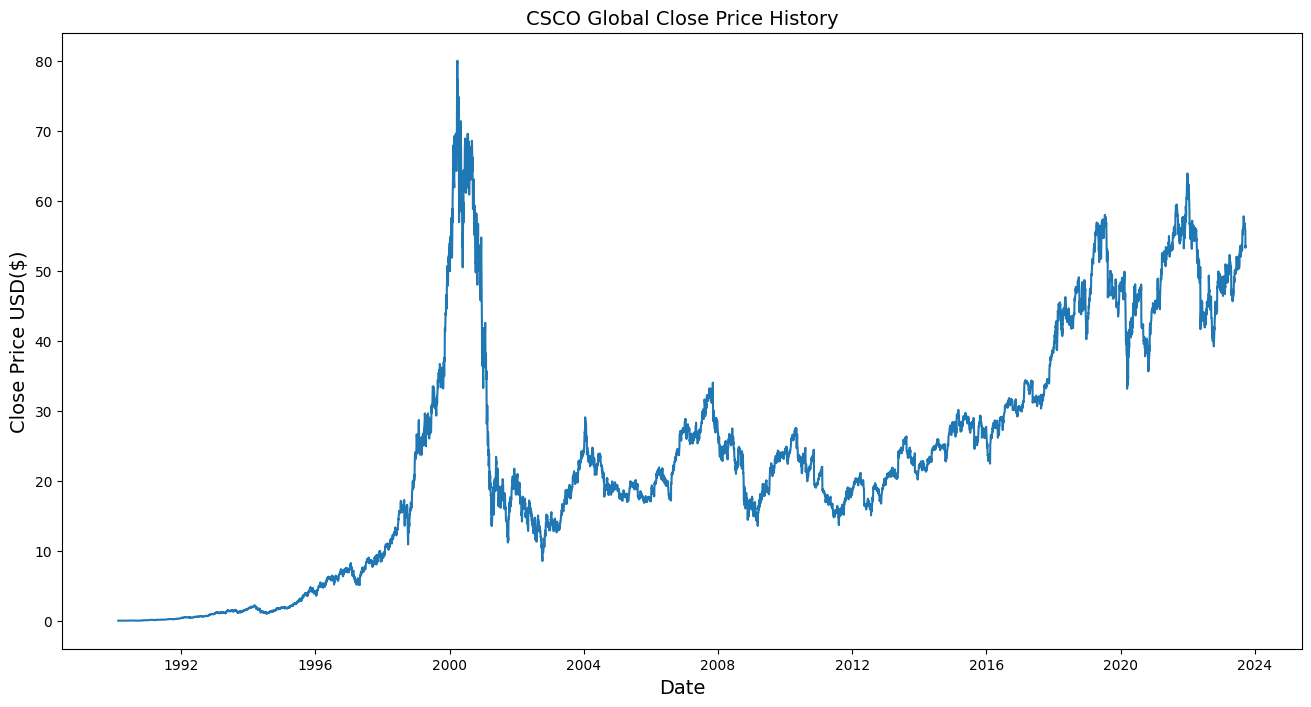

In [3]:
## Generate the figure of the whole closing price history

df = yf.download(stock)
plt.figure(figsize=(16,8))
plt.title(stock+' Global Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

In [4]:
## Get the stock quote

start_date = datetime.datetime(2002, 10, 1)
# end_date = datetime.datetime(2019, 12, 17)

df = yf.download(stock, start=start_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-10-01,10.660000,11.010000,10.130000,10.94,7.592205,109859600
2002-10-02,10.720000,10.750000,9.760000,10.05,6.974560,151829300
2002-10-03,9.980000,10.150000,9.670000,9.81,6.808001,137709000
2002-10-04,9.980000,10.130000,9.420000,9.46,6.565108,103389600
2002-10-07,9.210000,9.470000,8.750000,9.08,6.301393,130579400
...,...,...,...,...,...,...
2023-09-19,56.180000,56.209999,55.459999,55.84,55.840000,10748500
2023-09-20,55.950001,56.049999,55.439999,55.50,55.500000,12219900
2023-09-21,53.410000,54.099998,52.849998,53.34,53.340000,37436100


## Selected range of Close Price History
___

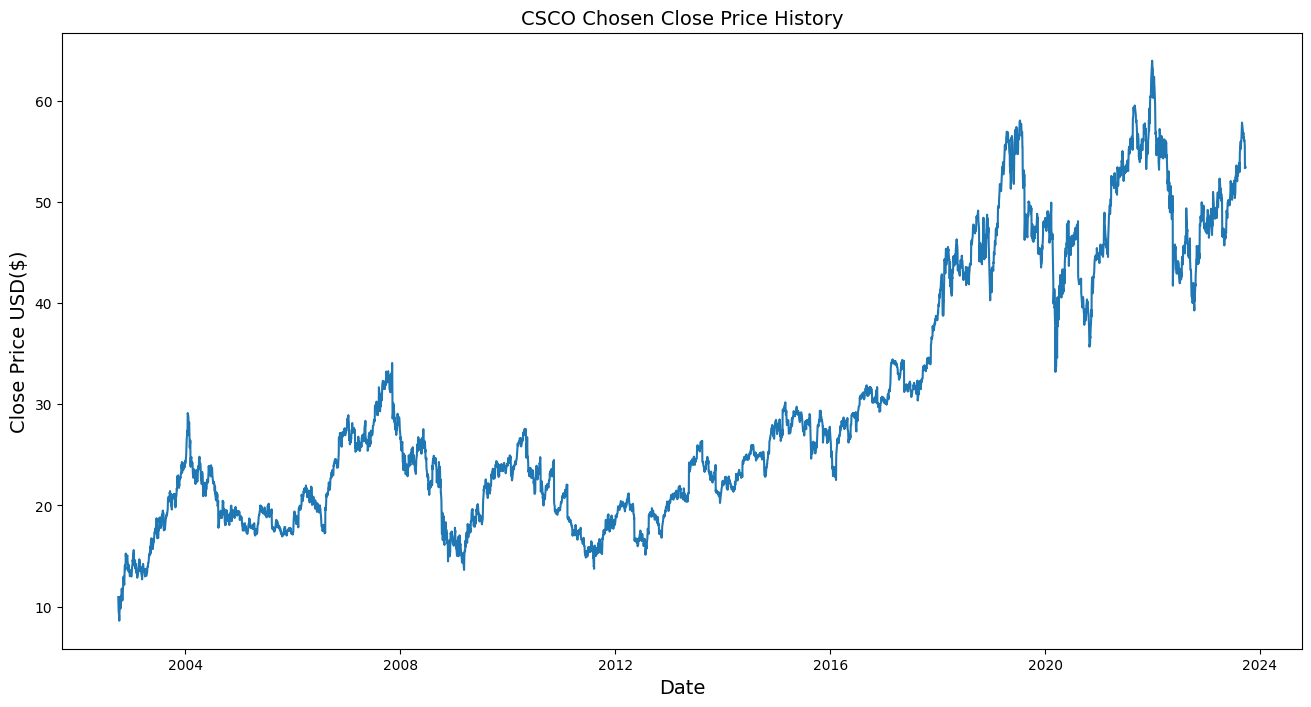

In [5]:
plt.figure(figsize=(16,8))
plt.title(stock+' Chosen Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

## Data Processing
---

In [6]:
data = df[['Close']]
dataset = data.values  

## Get the length of training data 
training_data_len = math.ceil(len(dataset)*0.8)   ## Ratio of Train and Test set is 8:2
training_data_len

4226

In [7]:
## Scale the data by MinMax Method

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset)

In [8]:
## Hyperparameters for the training approach 

window_interval = 60  ## No. of historical records(days) for the closing price of a day
delay = 8  ## i.e. the No. of future days that we can do prediction

In [9]:
## Group the training_data of the designed value (i.e. window_interval)

train_data = scaled_data[0:training_data_len]  

x_train = []
y_train = []

for i in range(window_interval+delay, len(train_data)):
    x_train.append(train_data[i-window_interval-delay:i-delay,0])
    y_train.append(train_data[i,0])


In [10]:
## Convert the data type of x_train and y_train into Array

x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
## Reshape the data for LSTM model

i,j = x_train.shape
x_train_reshaped = np.reshape(x_train,(i,j,1))
x_train_reshaped.shape


(4158, 60, 1)

## Modeling
---

In [12]:
## Hyperparameters for the Model

num_cells_layer1 = 128
num_cells_layer2 = None
num_batch_size = 1
num_epochs = 2

In [13]:
## Build the LSTM Model

model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape= (j,1)))
model.add(LSTM(num_cells_layer1 , return_sequences=False, input_shape=(j,1)))

model.add(Dense(25))
model.add(Dense(1))

In [14]:
## Comple the model

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [15]:
## Train the model

model.fit(x_train, y_train, batch_size = num_batch_size, epochs=num_epochs)

Epoch 1/2
4158/4158 [==============================] - 85s 20ms/step - loss: 0.0011
Epoch 2/2
4158/4158 [==============================] - 86s 21ms/step - loss: 7.9475e-04


In [16]:
## Group the training_data of the designed value (i.e. window_interval)

test_data = scaled_data[training_data_len-window_interval:]

x_test = []
y_test = dataset[training_data_len:,]

for i in range (window_interval,len(test_data)):
    x_test.append(test_data[i-window_interval:i,0])


In [17]:
x_test = np.array(x_test)
i,j = x_test.shape
x_test = np.reshape(x_test,(i,j,1))   
x_test

array([[[0.86235551],
        [0.86867773],
        [0.87210986],
        ...,
        [0.89143789],
        [0.89324422],
        [0.88547687]],

       [[0.86867773],
        [0.87210986],
        [0.8621749 ],
        ...,
        [0.89324422],
        [0.88547687],
        [0.87807081]],

       [[0.87210986],
        [0.8621749 ],
        [0.85404628],
        ...,
        [0.88547687],
        [0.87807081],
        [0.88764455]],

       ...,

       [[0.76336707],
        [0.76354768],
        [0.7696893 ],
        ...,
        [0.85820089],
        [0.85332372],
        [0.84718209]],

       [[0.76354768],
        [0.7696893 ],
        [0.77926305],
        ...,
        [0.85332372],
        [0.84718209],
        [0.80816475]],

       [[0.7696893 ],
        [0.77926305],
        [0.7807081 ],
        ...,
        [0.84718209],
        [0.80816475],
        [0.81231937]]])

In [18]:
## Do the prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # transform the value back by MinMaxScaler
len_predictions = len(predictions)

33/33 [==============================] - 3s 45ms/step


In [19]:
len_predictions = len(predictions)

## Plot the Data
---

/var/folders/0c/4yyxy27966j8h86h_vwsy3680000gn/T/ipykernel_22078/612198707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


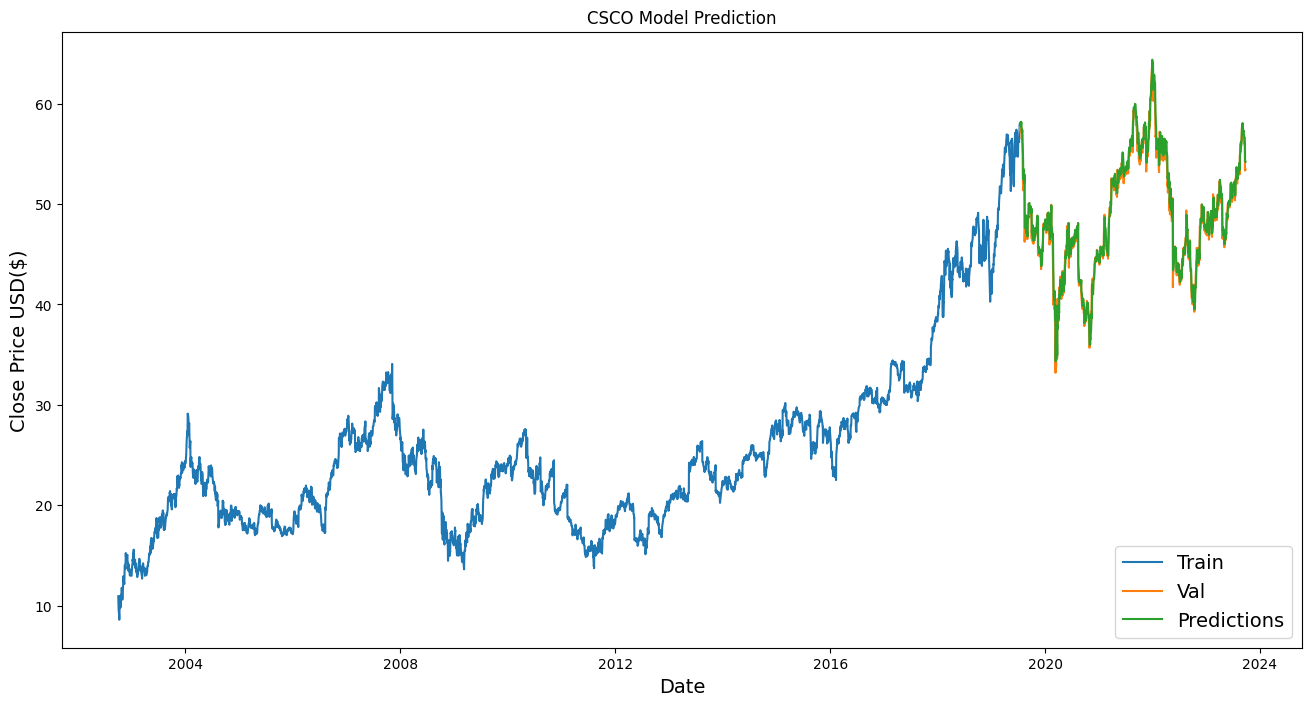

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.title(stock+' Model Prediction')
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Val','Predictions'], loc = 'lower right', fontsize = 14)
plt.show()

## RMSE
---
Measure how the model fit the test set data. <br>
We pursue the model that best fits the test set data.

In [21]:
rmse = np.sqrt(np.mean((y_test - predictions)**2))
rmse

0.8986255475880541

## Set a break
---
If the model trained is not ideal, we don't need it.
So, we set a break before saving it

In [70]:
pdb.set_trace()

--Call--
> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 

    253     def finish_displayhook(self):
    254         """Finish up all displayhook activities."""
    255         sys.stdout.write(self.shell.separate_out2)
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 
    261         This is invoked every time the interpreter needs to print, and is
    262         activated by setting the variable sys.displayhook to it.
    263         """

*** NameError: name 'Esc' is not defined
*** NameError: name 'Enter' is not defined
*** NameError: name 'Enter' is not defined
*** NameError: name 'Enter' is not defined
*** NameError: name 'Enter' is not defined
*

## Save the model
---

In [22]:
## Save the model and Generate the directory of the model

model.save(stock+'_model')

INFO:tensorflow:Assets written to: CSCO_model/assets


INFO:tensorflow:Assets written to: CSCO_model/assets


In [23]:
## Store the info of hyperparameters for the model

model_info_text = """## Model Info 
Stock:                     {}
num of days of prediction: {}
LSTM Cells for layer1:     {}
Epoches:                   {}
batch_size:                {}
window for prediction:     {}
---------------------------------------
## Model Result
Test set length:           {}
RMSE:                      {}""".format(stock, delay, num_cells_layer1, num_epochs, num_batch_size, window_interval, len_predictions, rmse)


In [24]:
## generate the file inside the directory of the model

file_name = "model_info.txt"

file_path = os.path.join(stock+'_model', file_name)


with open(file_path, 'w') as file:
    file.write(model_info_text)


## Save the Prediction and Actual Closing Price
---

In [25]:
valid

,Close,Predictions
Date,,
2019-07-17,57.209999,58.083118
2019-07-18,57.740002,57.752495
2019-07-19,57.360001,58.155945
2019-07-22,57.730000,57.896580
2019-07-23,57.709999,58.168373
...,...,...
2023-09-19,55.840000,56.597443
2023-09-20,55.500000,56.367077
2023-09-21,53.340000,56.054028


In [26]:
## Save the prediction as csv file in the directory of the model

valid.to_csv(os.path.join(stock+'_model',"prediction.csv"), index=True)

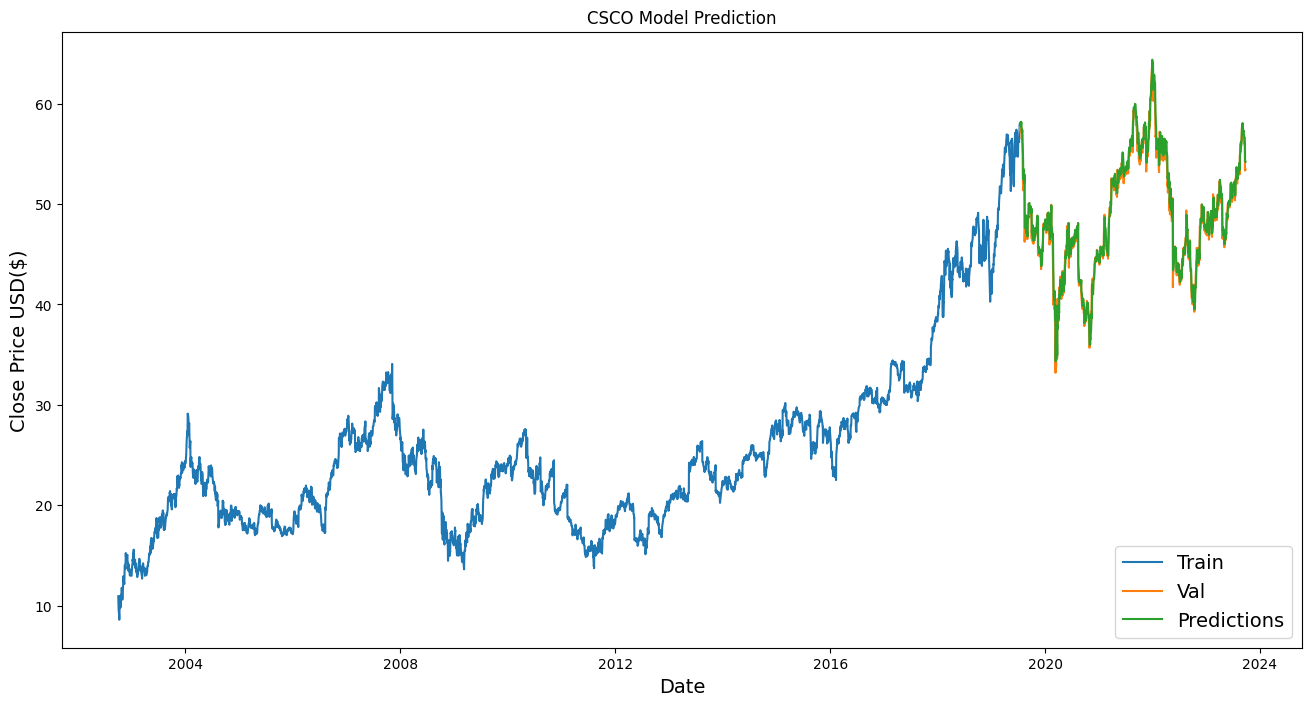

In [27]:
## Save the visible graph of prediction in the directory of the model

# Please note that the picture should not be used to measure the degree of how fit the mode is to the test set, 
# comparing to the value of RMSE or other loss indicators

plt.figure(figsize = (16,8))
plt.title(stock+' Model Prediction')
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Val','Predictions'], loc = 'lower right', fontsize = 14)
plt.savefig(os.path.join(stock+'_model',"prediction.jpg"))